In [1]:
from libs.can import CANSocket
from libs.myactuator import MyActuator
from time import perf_counter

import numpy as np

# import getpass
# password = getpass.getpass()

# the serial port of device
# you may find one by examing /dev/ folder,
# this is usually devices ttyACM
# os.system(f"sudo slcand -o -c -s8 /dev/serial/by-id/usb-Protofusion_Labs_CANable_8c005eb_https\:__github.com_normaldotcom_cantact-fw.git_001D00335734570920343135-if00 can0")

serial_device = "ttyACM1"

# Initiate the can bus socket
can_bus = CANSocket(serial_port=serial_device)

# Initiate motor
motor = MyActuator(can_bus=can_bus)

# Set the control loop timings
frequency = 500
sampling_time = 1 / frequency


def stop_motor(motor):
    for _ in range(100):
        motor.set_current(0)


# total working time
T = 3
N = T * frequency + 100

# for each p_gain, we have a plot for d_gains
p_gains = [120, 180]
d_gains = [5, 10, 25]
p_n = len(p_gains)
d_n = len(d_gains)

angles = np.zeros((p_n, d_n, N))
velocities = np.zeros((p_n, d_n, N))
times = np.zeros(N)

angle_initial = 2
angle_desired = 0

velocity_desired = 0

motor.set_current(0)

try:
    for k in range(p_n):
        for l in range(d_n):
            i = 0
            last_execution = 0
            control = 0
            # find the global time before entering control loop
            initial_time = perf_counter()
            # motor.set_zero()
            initial_angle = motor.state["angle"] + angle_initial
            while True:
                time = perf_counter() - initial_time  # get actual time in secs
                # /////////////////////////
                # Get and parse motor state
                # /////////////////////////
                state = motor.state
                theta = state["angle"] - initial_angle
                dtheta = state["speed"]
                current = state["current"]

                # ///////////////////////////////////////////
                # Update the control only on specific timings
                # ///////////////////////////////////////////

                # P-control
                if (time - last_execution) >= sampling_time:
                    if i < N:
                        angles[k, l, i] = theta
                        velocities[k, l, i] = dtheta
                        times[i] = time
                    else: 
                        break
                    
                    i += 1

                    last_execution = time
                    # YOUR CONTROLLER GOES HERE
                    control = -p_gains[k] * (theta - angle_desired) - d_gains[l] * (dtheta - velocity_desired)

                motor.set_current(control)

        stop_motor(motor)

except KeyboardInterrupt:

    stop_motor(motor)
    print("Disabled by interrupt")

motor = None

sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper


CAN device is connected on ttyACM1 / 115200 and up as interface <can0> with 1000000 bps
CAN interface <can0> is down
CAN interface <can0> is setted on 1000000 bps
CAN interface <can0> is up
CANDDevice was destructed


In [2]:
bound = 0.05
last_n = 10

def get_settling_time(x, ts):
    x_f = x[-1]
    is_setttled = np.all(np.abs(x[-last_n:] - x_f) <= bound)
    if not is_setttled:
        return -1
    diffs = (np.abs(x - x_f) <= bound)[::-1]
    j = 0
    n = len(diffs)
    for i in range(len(diffs)):
        if diffs[i] == False:
            j = i
            break
    return ts[n - j - 1]


def get_overshoot(x):
    final_value = np.abs(x[-1])
    max_diff = np.max(x[x-final_value >= 0])
    return max_diff


def get_steady_state_error(x, x_d):
    return np.abs(x[-1] - x_d)

def get_characteristics(x, x_d, ts):
    settling_time = get_settling_time(x, ts)
    if settling_time == -1:
        return [-100, -100, -100]
    overshoot = get_overshoot(x)
    steady_state_error = get_steady_state_error(x, x_d)
    return [settling_time, overshoot, steady_state_error]

def add_plot(ax, x, x_d, ts, p_gain, d_gain, for_angle=True):
    settling_time, overshoot, steady_state_error = get_characteristics(x, x_d, ts)
    overshoot_unit = "rad" if for_angle else "$\\frac{rad}{sec}$"
    ax.plot(
        ts,
        x,
        label=
        f"P-gain: {p_gain:.2f}, D-gain: {d_gain:.2f}, settling time: {settling_time:.2f}, overshoot: {overshoot:.2f} {overshoot_unit}, steady state error: {steady_state_error:.2f}",
    )

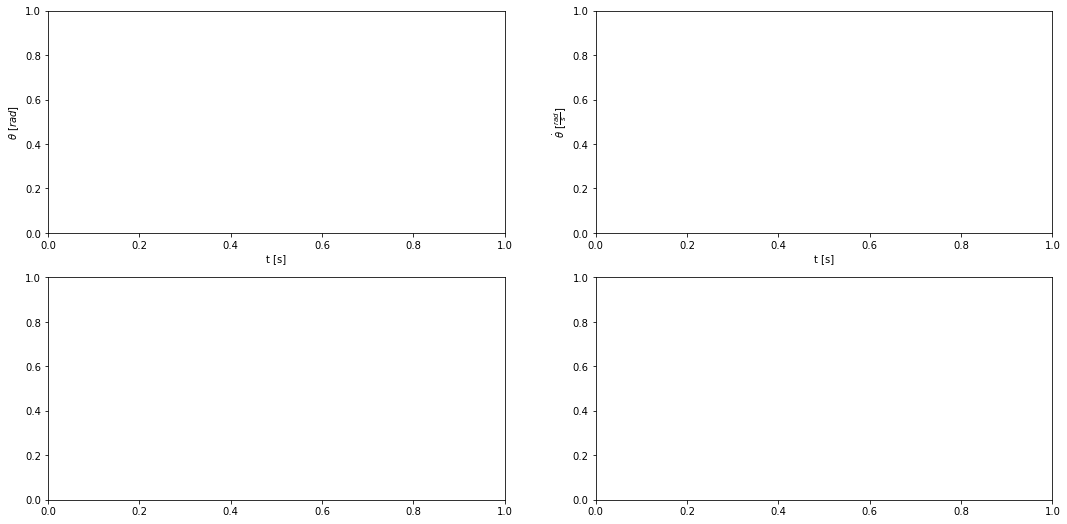

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(p_n, 2, figsize=(18, 9))

for i in range(p_n):

    ax0, ax1 = ax[i][0], ax[i][1]
    ax0.set_xlabel("t [s]")
    ax0.set_ylabel("$\\theta$ [$rad$]")

    ax1.set_xlabel("t [s]")
    ax1.set_ylabel("$\\dot{\\theta}$ [$\\frac{rad}{s}$]")

    for j in range(d_n):
        add_plot(ax=ax0, x=angles[i], x_d=angle_desired, ts=times, p_gain=p_gains[i], d_gain=d_gains[j], for_angle=True)
        add_plot(ax=ax1, x=velocities[i], x_d=velocity_desired, ts=times, p_gain=p_gains[i], d_gain=d_gains[j], for_angle=False)
    
    des = np.zeros(N)
    ax0.plot(times, des, label = "$\\theta_{{desired}}$")
    ax0.legend()
    ax1.legend()


fig.suptitle(f"control loop frequency = {frequency} Hz, $\\theta_{{desired}}$ = {angle_desired}", fontsize="13")
fig.tight_layout(pad=3.0)

plt.savefig("./plots/2.2.png")
plt.show()
